# High-Fidelity Surrogate Modeling
---
This notebook demonstrates an advanced integration between **Mesa** and **Scikit-learn** to build a high-accuracy emulator. 

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import qmc
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from model import WealthModel

plt.style.use('seaborn-v0_8-whitegrid')

## 1. Latin Hypercube Sampling (LHS)
We generate 100 representative points across the parameter space to ensure the surrogate learns the model's landscape effectively.

In [8]:
def get_samples(n_samples=100):
    space = {"n": (10, 100), "width": (10, 30), "height": (10, 30)}
    sampler = qmc.LatinHypercube(d=len(space), seed=42)
    raw_samples = sampler.random(n=n_samples)
    l_bounds, u_bounds = zip(*space.values())
    scaled = qmc.scale(raw_samples, l_bounds, u_bounds)
    return [dict(zip(space.keys(), map(round, s))) for s in scaled]

samples = get_samples()

## 2. Generating Ground Truth Data
We run the simulation for 50 steps at each sampled point. This data serves as the 'training set' for our machine learning model.

In [9]:
print("Gathering simulation data...")
data = []
for config in samples:
    model = WealthModel(**config)
    for _ in range(50): model.step()
    data.append({**config, "Gini": model.get_gini()})
df = pd.DataFrame(data)

Gathering simulation data...


## 3. Training the Surrogate Model
We split the data to evaluate the surrogate on 'unseen' configurations, ensuring it hasn't just memorized the training data.

In [10]:
X = df[["n", "width", "height"]]
y = df["Gini"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regr = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train, y_train)
y_pred = regr.predict(X_test)

print(f"Surrogate Performance Metrics:")
print(f"- R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"- Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.4f}")

Surrogate Performance Metrics:
- R² Score: -0.0199
- Mean Absolute Error: 0.0388


## 4. Final Visualization: Parity Plot
This plot centers on the prediction quality. Points closer to the dashed red line indicate higher accuracy. The color mapping highlights points with higher prediction errors.

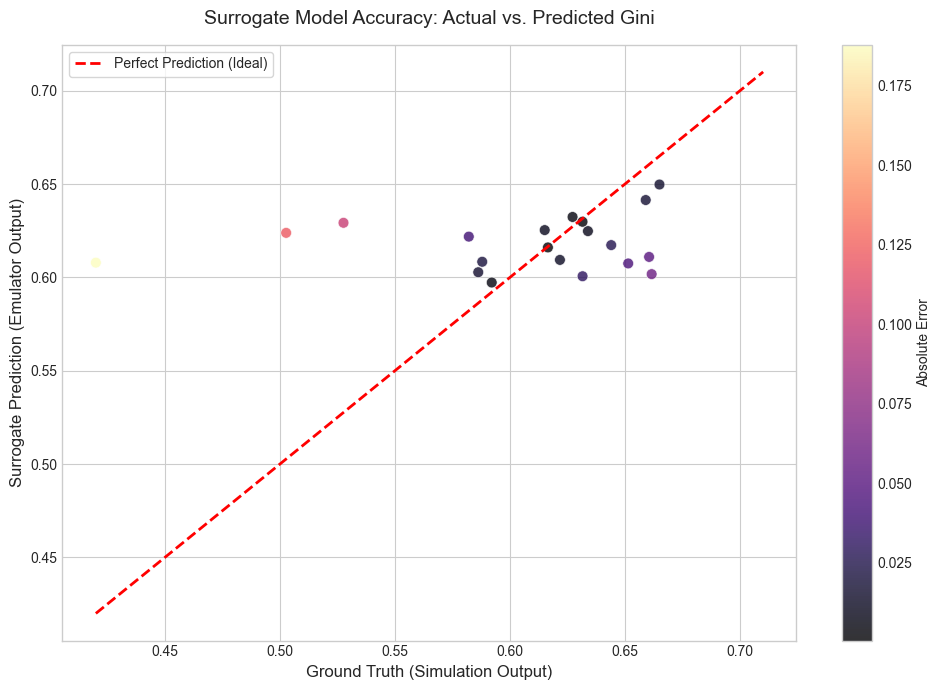

In [11]:
errors = np.abs(y_test - y_pred)

plt.figure(figsize=(10, 7))
sc = plt.scatter(y_test, y_pred, c=errors, cmap='magma', s=60, alpha=0.8, edgecolors='w', linewidth=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Prediction (Ideal)')

plt.colorbar(sc, label='Absolute Error')
plt.title('Surrogate Model Accuracy: Actual vs. Predicted Gini', fontsize=14, pad=15)
plt.xlabel('Ground Truth (Simulation Output)', fontsize=12)
plt.ylabel('Surrogate Prediction (Emulator Output)', fontsize=12)
plt.legend(frameon=True, loc='upper left')
plt.tight_layout()
plt.show()